# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [1]:
import os
import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from Utils.context_fid import Context_FID
from Utils.metric_utils import display_scores
from Utils.cross_correlation import CrossCorrelLoss

## Setting and Training

### Build dataset and settings

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/jumping.yaml'
        self.save_dir = './jumping'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)
# trainer.load(milestone=25, verbose=True)

/home/jx/chenghao/Diffusion-CSI/Utils/Data_utils/csi_datasets.py:168: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_try = pd.read_csv(filepath, header=None)


[read_data] jumping.csv -> shape: (1727000, 56); columns: 56
[Transformer] Frequency-attention ENABLED: freq_heads=2, head_dim=16, F=56
[Diffusion_TS] kwargs.use_freq_attn=True, freq_heads=2, freq_d_model=16, freq_dropout=0.1
[Diffusion_TS] Initialized with seq_length=500, feature_size=56, use_ff=False, corr_weight=0.05


In [3]:
# Inspect config flags for frequency-attention
try:
    model_params = configs.get('model', {}).get('params', {})
    print('[Notebook] use_freq_attn in config:', model_params.get('use_freq_attn', None))
    print('[Notebook] freq params snapshot:', {
        'freq_heads': model_params.get('freq_heads'),
        'freq_d_model': model_params.get('freq_d_model'),
        'freq_dropout': model_params.get('freq_dropout')
    })
except Exception as e:
    print('Config inspection error:', e)

[Notebook] use_freq_attn in config: True
[Notebook] freq params snapshot: {'freq_heads': 2, 'freq_d_model': 16, 'freq_dropout': 0.1}


### Training models

  0%|          | 0/20000 [00:00<?, ?it/s]

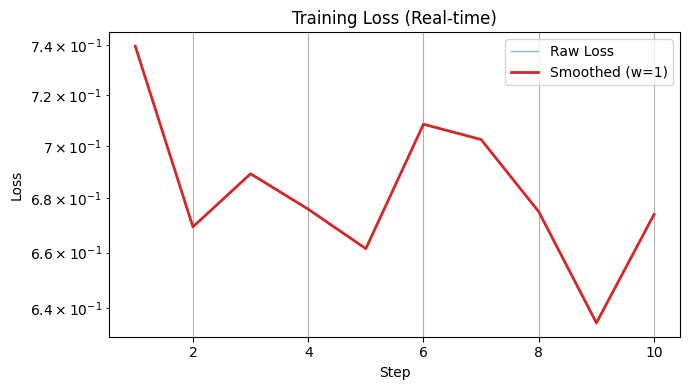

Training complete. Loss curve saved to Result/Checkpoints_jumping_500/loss_curve.png
CSV log saved to Result/Checkpoints_jumping_500/loss_log.csv


In [4]:
trainer.train()

## Inference and Visualizations

### Sampling

In [4]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.n_features
ori_data = np.load(os.path.join(dataset.dir, f"jumping_norm_truth_{seq_length}_train.npy"))
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy"))  # Uncomment the line if dataset other than Sine is used.
fake_data = trainer.sample(num=len(dataset), size_every=350, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_jumping.npy'), fake_data)

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

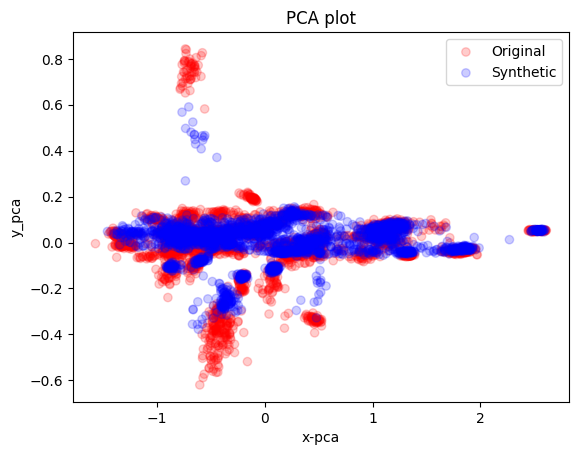

In [5]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

/home/jx/anaconda3/envs/Diff/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jx/anaconda3/envs/Diff/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6564 samples in 0.002s...
[t-SNE] Computed neighbors for 6564 samples in 0.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6564
[t-SNE] Computed conditional probabilities for sample 2000 / 6564
[t-SNE] Computed conditional probabilities for sample 3000 / 6564
[t-SNE] Computed conditional probabilities for sample 4000 / 6564
[t-SNE] Computed conditional probabilities for sample 5000 / 6564
[t-SNE] Computed conditional probabilities for sample 6000 / 6564
[t-SNE] Computed conditional probabilities for sample 6564 / 6564
[t-SNE] Mean sigma: 0.035105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.409676
[t-SNE] KL divergence after 300 iterations: 1.603669


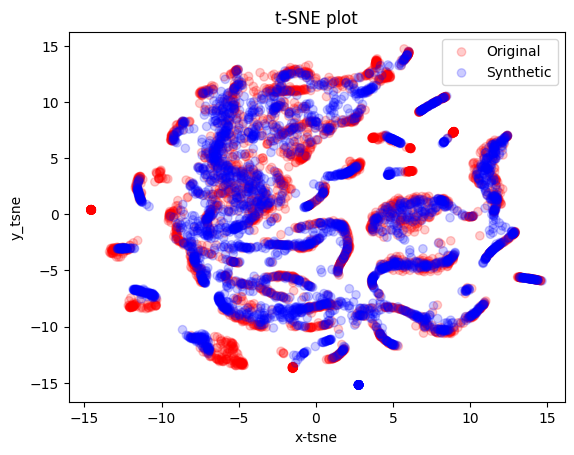

In [6]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

/home/jx/chenghao/Diffusion-CSI/Utils/metric_utils.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/home/jx/chenghao/Diffusion-CSI/Utils/metric_utils.py:158: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bb

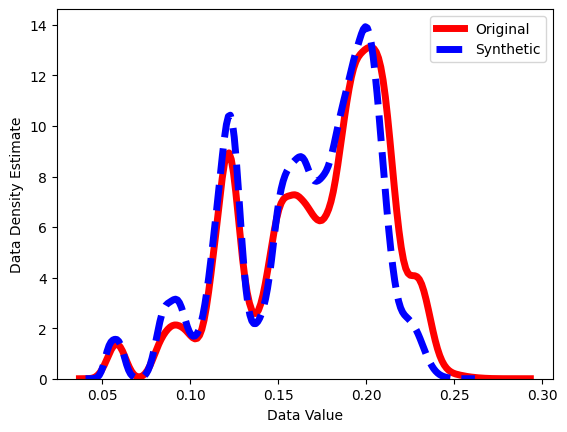

In [7]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])

In [8]:
iterations = 5
ori_data = np.load('./jumping/samples/jumping_norm_truth_500_train.npy')
fake_data = np.load('./jumping/ddpm_fake_jumping.npy')

context_fid_score = []

for i in range(iterations):
    context_fid = Context_FID(ori_data[:], fake_data[:ori_data.shape[0]])
    context_fid_score.append(context_fid)
    print(f'Iter {i}: ', 'context-fid =', context_fid, '\n')
      
display_scores(context_fid_score)

Iter 0:  context-fid = 0.6562886467715617 

Iter 1:  context-fid = 0.6467158004517264 

Iter 2:  context-fid = 0.6211284494173923 

Iter 3:  context-fid = 0.5451734493722467 

Iter 4:  context-fid = 0.6198953457486195 

Final Score:  0.6178403383523093 ± 0.054149848930162704


In [9]:
def random_choice(size, num_select=100):
    select_idx = np.random.randint(low=0, high=size, size=(num_select,))
    return select_idx

x_real = torch.from_numpy(ori_data)
x_fake = torch.from_numpy(fake_data)

correlational_score = []
size = int(x_real.shape[0] / iterations)

for i in range(iterations):
    real_idx = random_choice(x_real.shape[0], size)
    fake_idx = random_choice(x_fake.shape[0], size)
    corr = CrossCorrelLoss(x_real[real_idx, :, :], name='CrossCorrelLoss')
    loss = corr.compute(x_fake[fake_idx, :, :])
    correlational_score.append(loss.item())
    print(f'Iter {i}: ', 'cross-correlation =', loss.item(), '\n')

display_scores(correlational_score)

Iter 0:  cross-correlation = 4.789648612833539 

Iter 1:  cross-correlation = 4.57442411967116 

Iter 2:  cross-correlation = 4.459908737623087 

Iter 3:  cross-correlation = 5.313121161531257 

Iter 4:  cross-correlation = 4.431844311117123 

Final Score:  4.713789388555233 ± 0.4512574455732772


In [ ]:
# Inspect all blocks' trend_scale / season_scale / gate_f like display_model.py
try:
    transformer = model.model  # Diffusion_TS -> Transformer
    dec_blocks = transformer.decoder.blocks
    enc_blocks = transformer.encoder.blocks

    print("[Notebook] model.model.use_freq_attn =", getattr(transformer, 'use_freq_attn', None))

    # Decoder blocks: print trend_scale, season_scale, gate_f (or NA)
    for i, blk in enumerate(dec_blocks):
        ts = getattr(blk, 'trend_scale', None)
        ss = getattr(blk, 'season_scale', None)
        gf = getattr(blk, 'gate_f', None)
        if ts is not None and ss is not None:
            if gf is not None:
                print(f"[DecoderBlock {i}] trend_scale={ts.item():.6f}, season_scale={ss.item():.6f}, gate_f={gf.item():.6f}")
            else:
                print(f"[DecoderBlock {i}] trend_scale={ts.item():.6f}, season_scale={ss.item():.6f}, gate_f=NA (freq-attn disabled)")
        else:
            print(f"[DecoderBlock {i}] trend_scale/season_scale not found")

    # Encoder blocks: only have gate_f for freq-attn branch
    for i, blk in enumerate(enc_blocks):
        gf = getattr(blk, 'gate_f', None)
        if gf is not None:
            print(f"[EncoderBlock {i}] gate_f={gf.item():.6f}")
        else:
            print(f"[EncoderBlock {i}] gate_f=NA (freq-attn disabled)")
except Exception as e:
    print("[Notebook] Inspection error:", e)